In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def load_data(table):
    df = pd.read_csv(f'rpc_18_inputs_for_participants//rpc_18_inputs_for_participants//RPC_18_Datasets//{table}.csv')
    return df

In [4]:
files = ['dim_customer','dim_delivery_partner_','dim_menu_item','dim_restaurant','fact_delivery_performance','fact_order_items','fact_orders','fact_ratings']

In [5]:
# lets have a look at successfull order first


In [66]:
# restaurnat with total 50+ pre-crisi orders
orders = load_data('fact_orders')
orders['order_timestamp'] = pd.to_datetime(orders['order_timestamp'])
orders['month'] = orders['order_timestamp'].dt.month

orders.head()

,order_id,customer_id,restaurant_id,delivery_partner_id,order_timestamp,subtotal_amount,discount_amount,delivery_fee,total_amount,is_cod,is_cancelled,month
0,ORD202501023439,CUST181110,REST08622,DP05541,2025-01-01 12:00:00,471.62,35.44,30.56,466.74,N,N,1
1,ORD202501012051,CUST025572,REST02383,DP08091,2025-01-01 12:00:00,255.68,0.00,27.45,283.13,Y,N,1
2,ORD202501019281,CUST179306,REST14069,DP02021,2025-01-01 12:00:00,428.38,0.00,26.23,454.61,N,N,1
3,ORD202501000124,CUST191820,REST19745,DP13859,2025-01-01 12:00:00,260.81,0.00,32.75,293.56,N,N,1
4,ORD202501006518,CUST033760,REST12962,DP09615,2025-01-01 12:00:00,280.33,0.00,25.57,305.90,N,N,1


In [67]:
restaurant = load_data('dim_restaurant')

In [68]:
restaurant.head()

,restaurant_id,restaurant_name,city,cuisine_type,partner_type,avg_prep_time_min,is_active
0,REST12962,Flavours of Sweets Palace,Bengaluru,Chinese,Restaurant,26-40,N
1,REST14069,Royal Biryani Darbar,Ahmedabad,Fast Food,Restaurant,16-25,Y
2,REST08622,Spicy Wraps Point,Mumbai,North Indian,Restaurant,16-25,Y
3,REST19745,Delhi Express Palace,Ahmedabad,Pizza,Cloud Kitchen,16-25,Y
4,REST02383,Namma Mess Delight,Mumbai,Healthy,Restaurant,26-40,Y


In [69]:
orders_with_restaurant = restaurant[['restaurant_id','restaurant_name']].merge(orders,on='restaurant_id',how='right')

In [70]:
orders_with_restaurant.head()

,restaurant_id,restaurant_name,order_id,customer_id,delivery_partner_id,order_timestamp,subtotal_amount,discount_amount,delivery_fee,total_amount,is_cod,is_cancelled,month
0,REST08622,Spicy Wraps Point,ORD202501023439,CUST181110,DP05541,2025-01-01 12:00:00,471.62,35.44,30.56,466.74,N,N,1
1,REST02383,Namma Mess Delight,ORD202501012051,CUST025572,DP08091,2025-01-01 12:00:00,255.68,0.00,27.45,283.13,Y,N,1
2,REST14069,Royal Biryani Darbar,ORD202501019281,CUST179306,DP02021,2025-01-01 12:00:00,428.38,0.00,26.23,454.61,N,N,1
3,REST19745,Delhi Express Palace,ORD202501000124,CUST191820,DP13859,2025-01-01 12:00:00,260.81,0.00,32.75,293.56,N,N,1
4,REST12962,Flavours of Sweets Palace,ORD202501006518,CUST033760,DP09615,2025-01-01 12:00:00,280.33,0.00,25.57,305.90,N,N,1


In [71]:
pre_crisis_orders = orders_with_restaurant[orders_with_restaurant['month']<=5]
crisis_orders = orders_with_restaurant[orders_with_restaurant['month']>5]

In [78]:
restaurant[['restaurant_id']].duplicated().sum()

np.int64(0)

In [79]:
restaurant[['restaurant_name']].duplicated().sum()

np.int64(15216)

there are name duplicates and we have analyzed that different branches of same restaurant has diff restaurant id so we will use name while calculating orders to avoid any miscarriage

In [122]:
order_count = (pre_crisis_orders.groupby('restaurant_name')
               .agg(pre_orders=('restaurant_name','count'))
               
               
               )
order_count.head()

,pre_orders
restaurant_name,
Annapurna Biryani Adda,31
Annapurna Biryani Bhojanalay,33
Annapurna Biryani Cafe,18
Annapurna Biryani Central,9
Annapurna Biryani Clouds,24


In [84]:
order_count.describe()

,pre_orders
count,4779.000000
mean,23.813769
std,12.294151
min,1.000000
25%,15.000000
50%,22.000000
75%,31.000000
max,82.000000


In [123]:
major_restaurant = order_count[order_count['pre_orders']>=50]
major_restaurant.head()

,pre_orders
restaurant_name,
Annapurna Biryani Delight,54
Annapurna Biryani Point,50
Annapurna Delights Clouds,50
Annapurna Delights Zone,53
Annapurna House Darbar,59


In [124]:
major_restaurant.describe()

,pre_orders
count,173.000000
mean,55.213873
std,5.698371
min,50.000000
25%,51.000000
50%,53.000000
75%,58.000000
max,82.000000


lets find decline in orders of these restaurants

crisis_orders.merge()

In [125]:
crisis_orders_grouped = ( crisis_orders.groupby('restaurant_name')
                         .agg(post_orders = ('restaurant_id','count'))
                         

)
crisis_orders_grouped.head()

,post_orders
restaurant_name,
Annapurna Biryani Adda,3
Annapurna Biryani Bhojanalay,15
Annapurna Biryani Cafe,10
Annapurna Biryani Central,4
Annapurna Biryani Clouds,9


In [126]:
order_decline_df = major_restaurant.merge(crisis_orders_grouped,on='restaurant_name',how='left')
order_decline_df

,pre_orders,post_orders
restaurant_name,,
Annapurna Biryani Delight,54,18
Annapurna Biryani Point,50,11
Annapurna Delights Clouds,50,15
Annapurna Delights Zone,53,13
Annapurna House Darbar,59,16
...,...,...
Urban Delights Delight,58,17
Urban Kitchen Zone,67,10
Urban Paratha Corner,59,18


In [127]:
order_decline_df['difference'] = order_decline_df['pre_orders'] - order_decline_df['post_orders']
order_decline_df['percent_decline'] = (order_decline_df['difference']/order_decline_df['pre_orders']).round(2) *100

order_decline_df.head()

,pre_orders,post_orders,difference,percent_decline
restaurant_name,,,,
Annapurna Biryani Delight,54,18,36,67.0
Annapurna Biryani Point,50,11,39,78.0
Annapurna Delights Clouds,50,15,35,70.0
Annapurna Delights Zone,53,13,40,75.0
Annapurna House Darbar,59,16,43,73.0


In [128]:
most_impacted_res = order_decline_df.sort_values(by='percent_decline',ascending=False).head(10)
most_impacted_res

,pre_orders,post_orders,difference,percent_decline
restaurant_name,,,,
Royal Curry Mahal,50,3,47,94.0
Taste of Cafe Corner,50,4,46,92.0
Flavours of Curry Cafe,53,5,48,91.0
Fresh Tandoor Delight,54,5,49,91.0
Urban Kitchen Zone,67,10,57,85.0
Grand Biryani Hub,50,8,42,84.0
Flavours of Tandoor Central,64,10,54,84.0
Hot & Crispy House Heaven,50,8,42,84.0
Punjabi Curry Delight,58,9,49,84.0


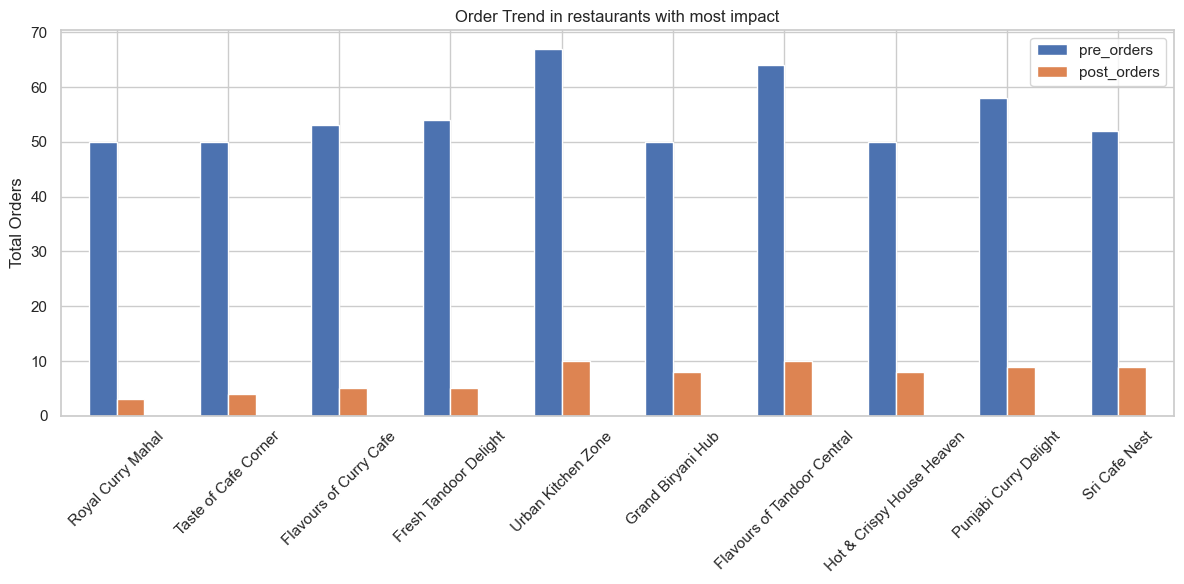

In [131]:
most_impacted_res[['pre_orders','post_orders']].plot(kind='bar',figsize=(12,6))
plt.title('Order Trend in restaurants with most impact')
plt.xlabel('')
plt.ylabel('Total Orders')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

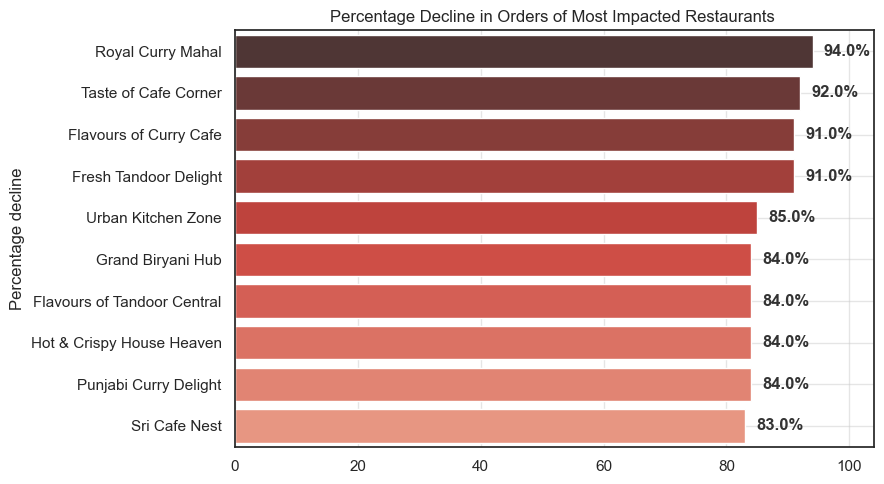

In [213]:
pal = sns.color_palette("Reds_d", n_colors=len(most_impacted_res))
pal = list(reversed(pal))


plt.figure(figsize=(9, 5))
ax = sns.barplot(data = most_impacted_res, x = 'percent_decline',y='restaurant_name',palette=pal,hue='restaurant_name')

for container in ax.containers:
    ax.bar_label(
        container, 
        label_type='edge', 
        padding=8,          # Adds space between the bar end and the text
        fontweight='bold', 
        color='#333333',     # Dark grey is often softer than pure black
        fmt='%.1f%%'
    )

plt.grid(alpha=0.5)
plt.title(f'Percentage Decline in Orders of Most Impacted Restaurants ')
plt.ylabel('Percentage decline')
plt.xlabel('')

current_max = most_impacted_res['percent_decline'].max()
plt.xlim(0, current_max + 10)

plt.tight_layout()
plt.show()

how many restaurants had more than 25% impact

In [210]:
order_decline_df.describe()

,pre_orders,post_orders,difference,percent_decline
count,173.000000,173.000000,173.000000,173.000000
mean,55.213873,15.543353,39.670520,71.832370
std,5.698371,4.598360,5.881692,7.834086
min,50.000000,3.000000,25.000000,49.000000
25%,51.000000,12.000000,36.000000,67.000000
50%,53.000000,15.000000,39.000000,71.000000
75%,58.000000,18.000000,42.000000,77.000000
max,82.000000,30.000000,59.000000,94.000000


In [212]:
order_decline_df[order_decline_df['percent_decline']>50]

,pre_orders,post_orders,difference,percent_decline
restaurant_name,,,,
Annapurna Biryani Delight,54,18,36,67.0
Annapurna Biryani Point,50,11,39,78.0
Annapurna Delights Clouds,50,15,35,70.0
Annapurna Delights Zone,53,13,40,75.0
Annapurna House Darbar,59,16,43,73.0
...,...,...,...,...
Urban Delights Delight,58,17,41,71.0
Urban Kitchen Zone,67,10,57,85.0
Urban Paratha Corner,59,18,41,69.0


lets have a look at drop in average rating

In [181]:
orders.head()

,order_id,customer_id,restaurant_id,delivery_partner_id,order_timestamp,subtotal_amount,discount_amount,delivery_fee,total_amount,is_cod,is_cancelled,month
0,ORD202501023439,CUST181110,REST08622,DP05541,2025-01-01 12:00:00,471.62,35.44,30.56,466.74,N,N,1
1,ORD202501012051,CUST025572,REST02383,DP08091,2025-01-01 12:00:00,255.68,0.00,27.45,283.13,Y,N,1
2,ORD202501019281,CUST179306,REST14069,DP02021,2025-01-01 12:00:00,428.38,0.00,26.23,454.61,N,N,1
3,ORD202501000124,CUST191820,REST19745,DP13859,2025-01-01 12:00:00,260.81,0.00,32.75,293.56,N,N,1
4,ORD202501006518,CUST033760,REST12962,DP09615,2025-01-01 12:00:00,280.33,0.00,25.57,305.90,N,N,1


In [182]:
ratings = load_data('fact_ratings')
ratings.head()

,order_id,customer_id,restaurant_id,rating,review_text,review_timestamp,sentiment_score
0,ORD202501023439,CUST181110,REST08622,4.5,Super fast delivery,01-01-2025 15:00,0.75
1,ORD202501019281,CUST179306,REST14069,4.5,Great taste!,01-01-2025 15:00,0.75
2,ORD202501018036,CUST093042,REST13907,5.0,Super fast delivery,01-01-2025 14:03,1.00
3,ORD202501007724,CUST110825,REST08451,4.0,Tasty but a bit late,01-01-2025 14:06,0.50
4,ORD202501002349,CUST181669,REST00225,4.4,Satisfied overall,01-01-2025 14:06,0.70


In [190]:
orders_with_ratings = orders.merge(ratings,on='order_id',how='inner')
orders_with_ratings.head()

,order_id,customer_id_x,restaurant_id_x,delivery_partner_id,order_timestamp,subtotal_amount,discount_amount,delivery_fee,total_amount,is_cod,is_cancelled,month,customer_id_y,restaurant_id_y,rating,review_text,review_timestamp,sentiment_score
0,ORD202501023439,CUST181110,REST08622,DP05541,2025-01-01 12:00:00,471.62,35.44,30.56,466.74,N,N,1,CUST181110,REST08622,4.5,Super fast delivery,01-01-2025 15:00,0.75
1,ORD202501019281,CUST179306,REST14069,DP02021,2025-01-01 12:00:00,428.38,0.00,26.23,454.61,N,N,1,CUST179306,REST14069,4.5,Great taste!,01-01-2025 15:00,0.75
2,ORD202501018036,CUST093042,REST13907,DP01276,2025-01-01 12:03:00,300.30,48.31,31.41,283.40,N,N,1,CUST093042,REST13907,5.0,Super fast delivery,01-01-2025 14:03,1.00
3,ORD202501007724,CUST110825,REST08451,DP03817,2025-01-01 12:06:00,164.43,34.19,40.57,170.81,Y,N,1,CUST110825,REST08451,4.0,Tasty but a bit late,01-01-2025 14:06,0.50
4,ORD202501002349,CUST181669,REST00225,DP11899,2025-01-01 12:06:00,362.00,0.00,33.33,395.33,N,N,1,CUST181669,REST00225,4.4,Satisfied overall,01-01-2025 14:06,0.70


In [191]:
orders_with_ratings.info()

<class 'pandas.DataFrame'>
RangeIndex: 68825 entries, 0 to 68824
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   order_id             68825 non-null  str           
 1   customer_id_x        68825 non-null  str           
 2   restaurant_id_x      68825 non-null  str           
 3   delivery_partner_id  68825 non-null  str           
 4   order_timestamp      68825 non-null  datetime64[us]
 5   subtotal_amount      68825 non-null  float64       
 6   discount_amount      68825 non-null  float64       
 7   delivery_fee         68825 non-null  float64       
 8   total_amount         68825 non-null  float64       
 9   is_cod               68825 non-null  str           
 10  is_cancelled         68825 non-null  str           
 11  month                68825 non-null  int32         
 12  customer_id_y        68825 non-null  str           
 13  restaurant_id_y      68825 non-null  str  

In [216]:
ratings_per_month = ( orders_with_ratings.groupby('month')
                        .agg(avg_rating = ('rating','mean'))
                        .reset_index()

)
ratings_per_month

,month,avg_rating
0,1,4.576851
1,2,4.398034
2,3,4.739867
3,4,4.292625
4,5,4.490320
5,6,2.584811
6,7,2.690036
7,8,2.400354
8,9,2.305317


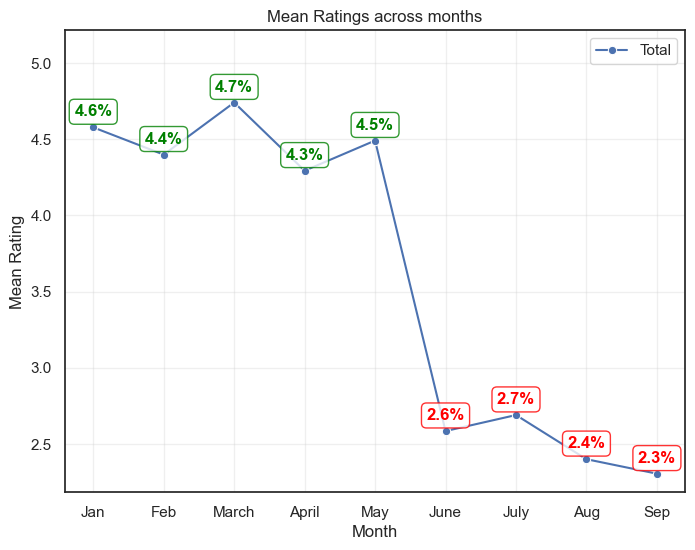

In [219]:
plt.figure(figsize=(8,6))
sns.lineplot(data= ratings_per_month,x = 'month',y='avg_rating',marker='o',color='b', label = 'Total')

for i,row in ratings_per_month.iterrows():
    if pd.notnull(row['avg_rating']):
        color_logic = 'green' if row['avg_rating'] >=4 else 'red'

        plt.annotate(
            f'{row['avg_rating']:.1f}%',
            xy = (row['month'],row['avg_rating']),
            xytext = (0,8),
            textcoords = 'offset points',
            color = color_logic,
            ha='center',
            fontweight='bold',
            bbox=dict(boxstyle='round', fc='white', ec=color_logic, alpha=0.8)

        )
plt.title('Mean Ratings across months')
plt.xlabel('Month')
plt.xticks([1,2,3,4,5,6,7,8,9],['Jan','Feb','March','April','May','June','July','Aug','Sep'])
plt.ylabel('Mean Rating')
plt.grid(alpha=0.3)
plt.ylim(top=ratings_per_month['avg_rating'].max()*1.1)
plt.legend()

plt.show()

In [201]:
monthly_stats=(
    orders.groupby(['month','is_cancelled'])['order_id']
    .count()
    .unstack()
    .rename(columns={'N':'Sucessfull','Y':'Failed'})
    .rename_axis(None,axis=1)

)
monthly_stats['total_orders'] = monthly_stats['Sucessfull']+monthly_stats['Failed']
monthly_stats['order_trend'] = monthly_stats['total_orders'].pct_change()*100
monthly_stats['fail_pct'] = (monthly_stats['Failed']/monthly_stats['total_orders'])*100


monthly_stats

,Sucessfull,Failed,total_orders,order_trend,fail_pct
month,,,,,
1,22076,1463,23539,NaN,6.215217
2,21272,1395,22667,-3.704490,6.154321
3,22133,1410,23543,3.864649,5.989041
4,20210,1256,21466,-8.822155,5.851113
5,21221,1370,22591,5.240846,6.064362
6,8219,1074,9293,-58.864149,11.557086
7,7768,1050,8818,-5.111374,11.907462
8,7485,1070,8555,-2.982536,12.507306
9,7670,1024,8694,1.624781,11.778238


In [202]:
monthly_stats_finalized = monthly_stats[['total_orders','order_trend','fail_pct']]
monthly_stats_finalized

,total_orders,order_trend,fail_pct
month,,,
1,23539,NaN,6.215217
2,22667,-3.704490,6.154321
3,23543,3.864649,5.989041
4,21466,-8.822155,5.851113
5,22591,5.240846,6.064362
6,9293,-58.864149,11.557086
7,8818,-5.111374,11.907462
8,8555,-2.982536,12.507306
9,8694,1.624781,11.778238


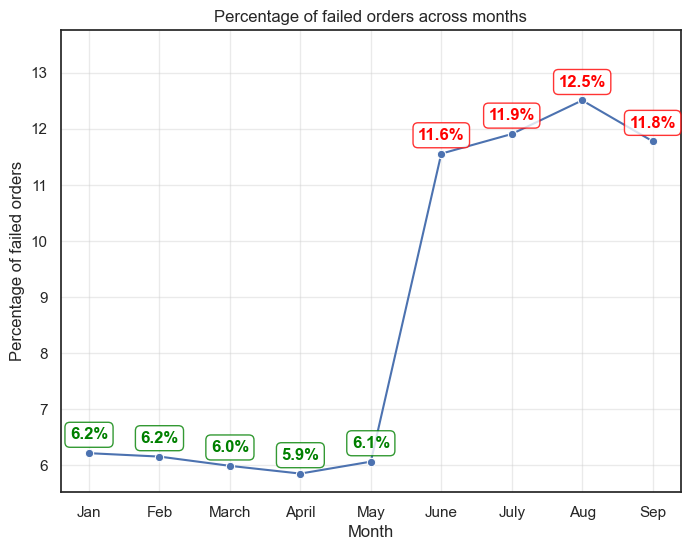

In [221]:
plt.figure(figsize=(8,6))

sns.lineplot(data=monthly_stats_finalized,x='month',y='fail_pct', marker='o', color='b')

for i,row in monthly_stats_finalized.iterrows():
    color_logic = 'green' if row['fail_pct'] <10 else 'red'
    plt.annotate(
        f'{row['fail_pct']:.1f}%',
        xy = (i,row['fail_pct']),
        xytext = (0,10),
        textcoords = 'offset points',
        ha = 'center',
        fontweight = 'bold',
        color = color_logic,
        bbox = dict(boxstyle='round',fc='white', ec = color_logic, alpha=0.8)
    )

plt.title('Percentage of failed orders across months')
plt.xticks(monthly_stats_finalized.index,['Jan','Feb','March','April','May','June','July','Aug','Sep'])

plt.xlabel('Month')
plt.ylabel('Percentage of failed orders')
plt.grid(alpha=0.4)

plt.ylim(top = monthly_stats_finalized['fail_pct'].max()*1.1)
plt.show()


lets have a look at delivery time across periods

In [223]:
delivery_perfromance = load_data("fact_delivery_performance")
delivery_perfromance.head()

,order_id,actual_delivery_time_mins,expected_delivery_time_mins,distance_km
0,ORD202501023439,31,31,6.4
1,ORD202501012051,46,42,1.9
2,ORD202501019281,25,31,6.2
3,ORD202501000124,29,41,6.2
4,ORD202501006518,37,41,2.4


In [229]:
orders_with_delivery_time = orders.merge(delivery_perfromance,on='order_id',how='right')
orders_with_delivery_time.head()

,order_id,customer_id,restaurant_id,delivery_partner_id,order_timestamp,subtotal_amount,discount_amount,delivery_fee,total_amount,is_cod,is_cancelled,month,actual_delivery_time_mins,expected_delivery_time_mins,distance_km
0,ORD202501023439,CUST181110,REST08622,DP05541,2025-01-01 12:00:00,471.62,35.44,30.56,466.74,N,N,1,31,31,6.4
1,ORD202501012051,CUST025572,REST02383,DP08091,2025-01-01 12:00:00,255.68,0.00,27.45,283.13,Y,N,1,46,42,1.9
2,ORD202501019281,CUST179306,REST14069,DP02021,2025-01-01 12:00:00,428.38,0.00,26.23,454.61,N,N,1,25,31,6.2
3,ORD202501000124,CUST191820,REST19745,DP13859,2025-01-01 12:00:00,260.81,0.00,32.75,293.56,N,N,1,29,41,6.2
4,ORD202501006518,CUST033760,REST12962,DP09615,2025-01-01 12:00:00,280.33,0.00,25.57,305.90,N,N,1,37,41,2.4


In [230]:
orders_with_delivery_time.info()

<class 'pandas.DataFrame'>
RangeIndex: 149166 entries, 0 to 149165
Data columns (total 15 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   order_id                     149166 non-null  str           
 1   customer_id                  149166 non-null  str           
 2   restaurant_id                149166 non-null  str           
 3   delivery_partner_id          143531 non-null  str           
 4   order_timestamp              149166 non-null  datetime64[us]
 5   subtotal_amount              149166 non-null  float64       
 6   discount_amount              149166 non-null  float64       
 7   delivery_fee                 149166 non-null  float64       
 8   total_amount                 149166 non-null  float64       
 9   is_cod                       149166 non-null  str           
 10  is_cancelled                 149166 non-null  str           
 11  month                        149166 n

In [231]:
orders_with_delivery_time['delay'] = orders_with_delivery_time['actual_delivery_time_mins'] - orders_with_delivery_time['expected_delivery_time_mins']
orders_with_delivery_time.head()

,order_id,customer_id,restaurant_id,delivery_partner_id,order_timestamp,subtotal_amount,discount_amount,delivery_fee,total_amount,is_cod,is_cancelled,month,actual_delivery_time_mins,expected_delivery_time_mins,distance_km,delay
0,ORD202501023439,CUST181110,REST08622,DP05541,2025-01-01 12:00:00,471.62,35.44,30.56,466.74,N,N,1,31,31,6.4,0
1,ORD202501012051,CUST025572,REST02383,DP08091,2025-01-01 12:00:00,255.68,0.00,27.45,283.13,Y,N,1,46,42,1.9,4
2,ORD202501019281,CUST179306,REST14069,DP02021,2025-01-01 12:00:00,428.38,0.00,26.23,454.61,N,N,1,25,31,6.2,-6
3,ORD202501000124,CUST191820,REST19745,DP13859,2025-01-01 12:00:00,260.81,0.00,32.75,293.56,N,N,1,29,41,6.2,-12
4,ORD202501006518,CUST033760,REST12962,DP09615,2025-01-01 12:00:00,280.33,0.00,25.57,305.90,N,N,1,37,41,2.4,-4
